In [ ]:
# links
https://brotherbored.com/guest-post-is-the-diplomacy-map-unbalanced/
http://ukdp.diplomatic-pouch.com/pouch/Zine/F2007R/Burton/statistician3.htm


In [1]:
path = "/data/oam_patel/AI_Diplomacy/results/20250218_234740/"

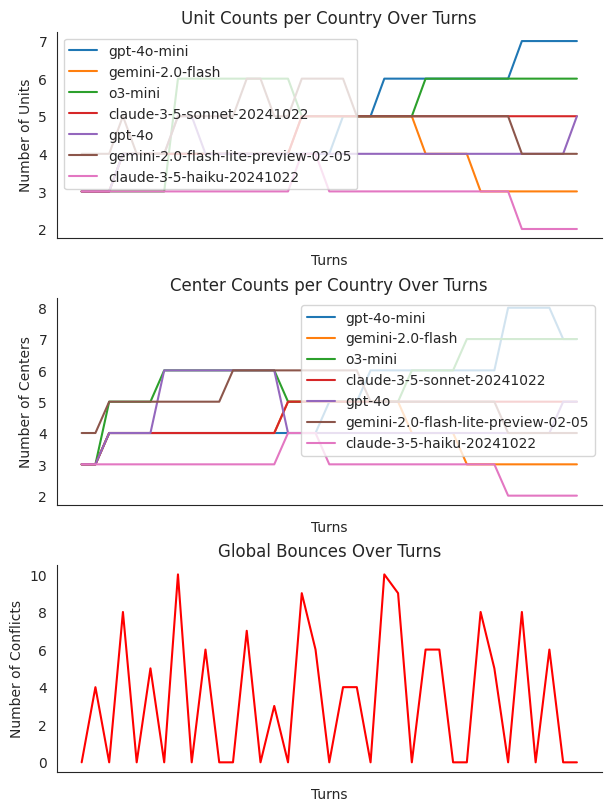

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style to "white"
sns.set_style("white")

# Load game data (adjust the filename as needed)
with open(path + 'lmvsgame.json', "r") as f:
    game_data = json.load(f)

# Define the list of countries
countries = ["AUSTRIA", "ENGLAND", "FRANCE", "GERMANY", "ITALY", "RUSSIA", "TURKEY"]

# load jsonl
with open(path + 'overview.jsonl', "r") as f:
    overview = [json.loads(line) for line in f]

model_map = overview[1]

# Prepare containers for our statistics over turns
turns = []  # List of phase names
unit_counts = {country: [] for country in countries}
center_counts = {country: [] for country in countries}
conflict_counts = []  # Global statistic per turn

# Iterate over each phase (turn) in the game
for phase in game_data.get("phases", []):
    turn_name = phase.get("name", "Unknown")
    turns.append(turn_name)

    state = phase.get("state", {})

    # Extract unit and center counts per country
    for country in countries:
        units = state.get("units", {}).get(country, [])
        centers = state.get("centers", {}).get(country, [])
        unit_counts[country].append(len(units))
        center_counts[country].append(len(centers))

    # Count conflicts: orders that resulted in a 'bounce'
    results = phase.get("results", {})
    conflicts = sum(1 for outcome in results.values() if "bounce" in outcome)
    conflict_counts.append(conflicts)

# Create subplots for the three statistics
fig, axs = plt.subplots(3, 1, figsize=(6, 8), constrained_layout=True)

# Plot unit counts per country
for country in countries:
    axs[0].plot(turns, unit_counts[country], label=model_map[country])
axs[0].set_title("Unit Counts per Country Over Turns")
axs[0].set_ylabel("Number of Units")
axs[0].set_xlabel("Turns")
axs[0].legend()
sns.despine(ax=axs[0], top=True, right=True)
axs[0].set_xticklabels([])  # Hide x-axis labels

# Plot center counts per country
for country in countries:
    axs[1].plot(turns, center_counts[country], label=model_map[country])
axs[1].set_title("Center Counts per Country Over Turns")
axs[1].set_ylabel("Number of Centers")
axs[1].set_xlabel("Turns")
axs[1].legend()
sns.despine(ax=axs[1], top=True, right=True)
axs[1].set_xticklabels([])  # Hide x-axis labels

# Plot global conflict counts
axs[2].plot(turns, conflict_counts, color="red")
axs[2].set_title("Global Bounces Over Turns")
axs[2].set_ylabel("Number of Conflicts")
axs[2].set_xlabel("Turns")
sns.despine(ax=axs[2], top=True, right=True)
axs[2].set_xticklabels([])  # Hide x-axis labels

plt.show()

In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 29.0 MB/s eta 0:00:00


In [4]:
text = '''**PLAYER DETAILS**

Power: AUSTRIA
Current phase: S1901M

**MAP DETAILS**

Abbreviations: 
{'ADRIATIC SEA': 'ADR', 'AEGEAN SEA': 'AEG', 'ALBANIA': 'ALB', 'ANKARA': 'ANK', 'APULIA': 'APU', 'ARMENIA': 'ARM', 'BALTIC SEA': 'BAL', 'BARENTS SEA': 'BAR', 'BELGIUM': 'BEL', 'BERLIN': 'BER', 'BLACK SEA': 'BLA', 'BOHEMIA': 'BOH', 'BREST': 'BRE', 'BUDAPEST': 'BUD', 'BULGARIA (EAST COAST)': 'BUL/EC', 'BULGARIA (SOUTH COAST)': 'BUL/SC', 'BULGARIA': 'BUL', 'BURGUNDY': 'BUR', 'CLYDE': 'CLY', 'CONSTANTINOPLE': 'CON', 'DENMARK': 'DEN', 'EASTERN MEDITERRANEAN': 'EAS', 'EDINBURGH': 'EDI', 'ENGLISH CHANNEL': 'ENG', 'FINLAND': 'FIN', 'GALICIA': 'GAL', 'GASCONY': 'GAS', 'GREECE': 'GRE', 'GULF OF LYON': 'LYO', 'GULF OF BOTHNIA': 'BOT', 'HELGOLAND BIGHT': 'HEL', 'HOLLAND': 'HOL', 'IONIAN SEA': 'ION', 'IRISH SEA': 'IRI', 'KIEL': 'KIE', 'LIVERPOOL': 'LVP', 'LIVONIA': 'LVN', 'LONDON': 'LON', 'MARSEILLES': 'MAR', 'MID-ATLANTIC OCEAN': 'MAO', 'MOSCOW': 'MOS', 'MUNICH': 'MUN', 'NAPLES': 'NAP', 'NORTH ATLANTIC OCEAN': 'NAO', 'NORTH AFRICA': 'NAF', 'NORTH SEA': 'NTH', 'NORWAY': 'NWY', 'NORWEGIAN SEA': 'NWG', 'PARIS': 'PAR', 'PICARDY': 'PIC', 'PIEDMONT': 'PIE', 'PORTUGAL': 'POR', 'PRUSSIA': 'PRU', 'ROME': 'ROM', 'RUHR': 'RUH', 'RUMANIA': 'RUM', 'SERBIA': 'SER', 'SEVASTOPOL': 'SEV', 'SILESIA': 'SIL', 'SKAGERRAK': 'SKA', 'SMYRNA': 'SMY', 'SPAIN (NORTH COAST)': 'SPA/NC', 'SPAIN (SOUTH COAST)': 'SPA/SC', 'SPAIN': 'SPA', 'ST PETERSBURG (NORTH COAST)': 'STP/NC', 'ST PETERSBURG (SOUTH COAST)': 'STP/SC', 'ST PETERSBURG': 'STP', 'SWEDEN': 'SWE', 'SYRIA': 'SYR', 'TRIESTE': 'TRI', 'TUNIS': 'TUN', 'TUSCANY': 'TUS', 'TYROLIA': 'TYR', 'TYRRHENIAN SEA': 'TYS', 'UKRAINE': 'UKR', 'VENICE': 'VEN', 'VIENNA': 'VIE', 'WALES': 'WAL', 'WARSAW': 'WAR', 'WESTERN MEDITERRANEAN': 'WES', 'YORKSHIRE': 'YOR', 'SWITZERLAND': 'SWI'}

Type of each location: 
{'ADR': 'WATER', 'AEG': 'WATER', 'ALB': 'COAST', 'ANK': 'COAST', 'APU': 'COAST', 'ARM': 'COAST', 'BAL': 'WATER', 'BAR': 'WATER', 'BEL': 'COAST', 'BER': 'COAST', 'BLA': 'WATER', 'BOH': 'LAND', 'BOT': 'WATER', 'BRE': 'COAST', 'BUD': 'LAND', 'BUL/EC': 'COAST', 'BUL/SC': 'COAST', 'bul': 'COAST', 'BUR': 'LAND', 'CLY': 'COAST', 'CON': 'COAST', 'DEN': 'COAST', 'EAS': 'WATER', 'EDI': 'COAST', 'ENG': 'WATER', 'FIN': 'COAST', 'GAL': 'LAND', 'GAS': 'COAST', 'GRE': 'COAST', 'HEL': 'WATER', 'HOL': 'COAST', 'ION': 'WATER', 'IRI': 'WATER', 'KIE': 'COAST', 'LON': 'COAST', 'LVN': 'COAST', 'LVP': 'COAST', 'LYO': 'WATER', 'MAO': 'WATER', 'MAR': 'COAST', 'MOS': 'LAND', 'MUN': 'LAND', 'NAF': 'COAST', 'NAO': 'WATER', 'NAP': 'COAST', 'NWY': 'COAST', 'NTH': 'WATER', 'NWG': 'WATER', 'PAR': 'LAND', 'PIC': 'COAST', 'PIE': 'COAST', 'POR': 'COAST', 'PRU': 'COAST', 'ROM': 'COAST', 'RUH': 'LAND', 'RUM': 'COAST', 'SER': 'LAND', 'SEV': 'COAST', 'SIL': 'LAND', 'SKA': 'WATER', 'SMY': 'COAST', 'SPA/NC': 'COAST', 'SPA/SC': 'COAST', 'spa': 'COAST', 'STP/NC': 'COAST', 'STP/SC': 'COAST', 'stp': 'COAST', 'SWE': 'COAST', 'SYR': 'COAST', 'TRI': 'COAST', 'TUN': 'COAST', 'TUS': 'COAST', 'TYR': 'LAND', 'TYS': 'WATER', 'UKR': 'LAND', 'VEN': 'COAST', 'VIE': 'LAND', 'WAL': 'COAST', 'WAR': 'LAND', 'WES': 'WATER', 'YOR': 'COAST', 'SWI': 'SHUT'}

Game map as an adjacency list: 
{'ADR': ['ALB', 'APU', 'ION', 'TRI', 'VEN'], 'AEG': ['BUL/SC', 'CON', 'EAS', 'GRE', 'ION', 'SMY'], 'ALB': ['ADR', 'GRE', 'ION', 'SER', 'TRI'], 'ANK': ['ARM', 'BLA', 'CON', 'smy'], 'APU': ['ADR', 'ION', 'NAP', 'rom', 'VEN'], 'ARM': ['ANK', 'BLA', 'SEV', 'smy', 'syr'], 'BAL': ['BER', 'BOT', 'DEN', 'LVN', 'KIE', 'PRU', 'SWE'], 'BAR': ['NWY', 'NWG', 'STP/NC'], 'BEL': ['BUR', 'ENG', 'HOL', 'NTH', 'PIC', 'RUH'], 'BER': ['BAL', 'KIE', 'MUN', 'PRU', 'SIL'], 'BLA': ['ANK', 'ARM', 'BUL/EC', 'CON', 'RUM', 'SEV'], 'BOH': ['GAL', 'MUN', 'SIL', 'TYR', 'VIE'], 'BOT': ['BAL', 'FIN', 'LVN', 'STP/SC', 'SWE'], 'BRE': ['ENG', 'GAS', 'MAO', 'PAR', 'PIC'], 'BUD': ['GAL', 'RUM', 'SER', 'TRI', 'VIE'], 'BUL/EC': ['BLA', 'CON', 'RUM'], 'BUL/SC': ['AEG', 'CON', 'GRE'], 'bul': ['AEG', 'BLA', 'CON', 'GRE', 'RUM', 'SER'], 'BUR': ['BEL', 'GAS', 'RUH', 'MAR', 'MUN', 'PAR', 'PIC', 'SWI'], 'CLY': ['EDI', 'LVP', 'NAO', 'NWG'], 'CON': ['AEG', 'BUL/EC', 'BUL/SC', 'BLA', 'ANK', 'SMY'], 'DEN': ['BAL', 'HEL', 'KIE', 'NTH', 'SKA', 'SWE'], 'EAS': ['AEG', 'ION', 'SMY', 'SYR'], 'EDI': ['CLY', 'lvp', 'NTH', 'NWG', 'YOR'], 'ENG': ['BEL', 'BRE', 'IRI', 'LON', 'MAO', 'NTH', 'PIC', 'WAL'], 'FIN': ['BOT', 'nwy', 'STP/SC', 'SWE'], 'GAL': ['BOH', 'BUD', 'RUM', 'SIL', 'UKR', 'VIE', 'WAR'], 'GAS': ['BUR', 'BRE', 'MAO', 'mar', 'PAR', 'SPA/NC'], 'GRE': ['AEG', 'ALB', 'BUL/SC', 'ION', 'SER'], 'HEL': ['DEN', 'HOL', 'KIE', 'NTH'], 'HOL': ['BEL', 'HEL', 'KIE', 'NTH', 'RUH'], 'ION': ['ADR', 'AEG', 'ALB', 'APU', 'EAS', 'GRE', 'NAP', 'TUN', 'TYS'], 'IRI': ['ENG', 'LVP', 'MAO', 'NAO', 'WAL'], 'KIE': ['BAL', 'BER', 'DEN', 'HEL', 'HOL', 'MUN', 'RUH'], 'LON': ['ENG', 'NTH', 'YOR', 'WAL'], 'LVN': ['BAL', 'BOT', 'MOS', 'PRU', 'STP/SC', 'WAR'], 'LVP': ['CLY', 'edi', 'IRI', 'NAO', 'WAL', 'yor'], 'LYO': ['MAR', 'PIE', 'SPA/SC', 'TUS', 'TYS', 'WES'], 'MAO': ['BRE', 'ENG', 'GAS', 'IRI', 'NAF', 'NAO', 'POR', 'SPA/NC', 'SPA/SC', 'WES'], 'MAR': ['BUR', 'gas', 'LYO', 'PIE', 'SPA/SC', 'SWI'], 'MOS': ['LVN', 'SEV', 'STP', 'UKR', 'WAR'], 'MUN': ['BER', 'BOH', 'BUR', 'KIE', 'RUH', 'SIL', 'TYR', 'SWI'], 'NAF': ['MAO', 'TUN', 'WES'], 'NAO': ['CLY', 'IRI', 'LVP', 'MAO', 'NWG'], 'NAP': ['APU', 'ION', 'ROM', 'TYS'], 'NWY': ['BAR', 'fin', 'NTH', 'NWG', 'SKA', 'STP/NC', 'SWE'], 'NTH': ['BEL', 'DEN', 'EDI', 'ENG', 'LON', 'HEL', 'HOL', 'NWY', 'NWG', 'SKA', 'YOR'], 'NWG': ['BAR', 'CLY', 'EDI', 'NAO', 'NWY', 'NTH'], 'PAR': ['BUR', 'BRE', 'GAS', 'PIC'], 'PIC': ['BEL', 'BRE', 'BUR', 'ENG', 'PAR'], 'PIE': ['LYO', 'MAR', 'TUS', 'TYR', 'ven', 'SWI'], 'POR': ['MAO', 'SPA/NC', 'SPA/SC'], 'PRU': ['BAL', 'BER', 'LVN', 'SIL', 'WAR'], 'ROM': ['apu', 'NAP', 'TUS', 'TYS', 'ven'], 'RUH': ['BEL', 'BUR', 'HOL', 'KIE', 'MUN'], 'RUM': ['BLA', 'BUD', 'BUL/EC', 'GAL', 'SER', 'SEV', 'UKR'], 'SER': ['ALB', 'BUD', 'BUL', 'GRE', 'RUM', 'TRI'], 'SEV': ['ARM', 'BLA', 'MOS', 'RUM', 'UKR'], 'SIL': ['BER', 'BOH', 'GAL', 'MUN', 'PRU', 'WAR'], 'SKA': ['DEN', 'NWY', 'NTH', 'SWE'], 'SMY': ['AEG', 'ank', 'arm', 'CON', 'EAS', 'SYR'], 'SPA/NC': ['GAS', 'MAO', 'POR'], 'SPA/SC': ['LYO', 'MAO', 'MAR', 'POR', 'WES'], 'spa': ['GAS', 'LYO', 'MAO', 'MAR', 'POR', 'WES'], 'STP/NC': ['BAR', 'NWY'], 'STP/SC': ['BOT', 'FIN', 'LVN'], 'stp': ['BAR', 'BOT', 'FIN', 'LVN', 'MOS', 'NWY'], 'SWE': ['BAL', 'BOT', 'DEN', 'FIN', 'NWY', 'SKA'], 'SYR': ['arm', 'EAS', 'SMY'], 'TRI': ['ADR', 'ALB', 'BUD', 'SER', 'TYR', 'VEN', 'VIE'], 'TUN': ['ION', 'NAF', 'TYS', 'WES'], 'TUS': ['LYO', 'PIE', 'ROM', 'TYS', 'ven'], 'TYR': ['BOH', 'MUN', 'PIE', 'TRI', 'VEN', 'VIE', 'SWI'], 'TYS': ['ION', 'LYO', 'ROM', 'NAP', 'TUN', 'TUS', 'WES'], 'UKR': ['GAL', 'MOS', 'RUM', 'SEV', 'WAR'], 'VEN': ['ADR', 'APU', 'pie', 'rom', 'TRI', 'tus', 'TYR'], 'VIE': ['BOH', 'BUD', 'GAL', 'TRI', 'TYR'], 'WAL': ['ENG', 'IRI', 'LON', 'LVP', 'yor'], 'WAR': ['GAL', 'LVN', 'MOS', 'PRU', 'SIL', 'UKR'], 'WES': ['MAO', 'LYO', 'NAF', 'SPA/SC', 'TUN', 'TYS'], 'YOR': ['EDI', 'LON', 'lvp', 'NTH', 'wal'], 'SWI': ['MAR', 'BUR', 'MUN', 'TYR', 'PIE']}

Possible coasts at each location: 
{'ADR': ['ADR'], 'AEG': ['AEG'], 'ALB': ['ALB'], 'ANK': ['ANK'], 'APU': ['APU'], 'ARM': ['ARM'], 'BAL': ['BAL'], 'BAR': ['BAR'], 'BEL': ['BEL'], 'BER': ['BER'], 'BLA': ['BLA'], 'BOH': ['BOH'], 'BOT': ['BOT'], 'BRE': ['BRE'], 'BUD': ['BUD'], 'BUL/EC': ['BUL/EC', 'BUL/SC', 'BUL'], 'BUL/SC': ['BUL/EC', 'BUL/SC', 'BUL'], 'BUL': ['BUL/EC', 'BUL/SC', 'BUL'], 'BUR': ['BUR'], 'CLY': ['CLY'], 'CON': ['CON'], 'DEN': ['DEN'], 'EAS': ['EAS'], 'EDI': ['EDI'], 'ENG': ['ENG'], 'FIN': ['FIN'], 'GAL': ['GAL'], 'GAS': ['GAS'], 'GRE': ['GRE'], 'HEL': ['HEL'], 'HOL': ['HOL'], 'ION': ['ION'], 'IRI': ['IRI'], 'KIE': ['KIE'], 'LON': ['LON'], 'LVN': ['LVN'], 'LVP': ['LVP'], 'LYO': ['LYO'], 'MAO': ['MAO'], 'MAR': ['MAR'], 'MOS': ['MOS'], 'MUN': ['MUN'], 'NAF': ['NAF'], 'NAO': ['NAO'], 'NAP': ['NAP'], 'NWY': ['NWY'], 'NTH': ['NTH'], 'NWG': ['NWG'], 'PAR': ['PAR'], 'PIC': ['PIC'], 'PIE': ['PIE'], 'POR': ['POR'], 'PRU': ['PRU'], 'ROM': ['ROM'], 'RUH': ['RUH'], 'RUM': ['RUM'], 'SER': ['SER'], 'SEV': ['SEV'], 'SIL': ['SIL'], 'SKA': ['SKA'], 'SMY': ['SMY'], 'SPA/NC': ['SPA/NC', 'SPA/SC', 'SPA'], 'SPA/SC': ['SPA/NC', 'SPA/SC', 'SPA'], 'SPA': ['SPA/NC', 'SPA/SC', 'SPA'], 'STP/NC': ['STP/NC', 'STP/SC', 'STP'], 'STP/SC': ['STP/NC', 'STP/SC', 'STP'], 'STP': ['STP/NC', 'STP/SC', 'STP'], 'SWE': ['SWE'], 'SYR': ['SYR'], 'TRI': ['TRI'], 'TUN': ['TUN'], 'TUS': ['TUS'], 'TYR': ['TYR'], 'TYS': ['TYS'], 'UKR': ['UKR'], 'VEN': ['VEN'], 'VIE': ['VIE'], 'WAL': ['WAL'], 'WAR': ['WAR'], 'WES': ['WES'], 'YOR': ['YOR'], 'SWI': ['SWI']}

All supply centers on the map: 
['BUD', 'TRI', 'VIE', 'EDI', 'LON', 'LVP', 'BRE', 'MAR', 'PAR', 'BER', 'KIE', 'MUN', 'NAP', 'ROM', 'VEN', 'MOS', 'SEV', 'STP', 'WAR', 'ANK', 'CON', 'SMY', 'BEL', 'BUL', 'DEN', 'GRE', 'HOL', 'NWY', 'POR', 'RUM', 'SER', 'SPA', 'SWE', 'TUN']

**HISTORICAL SUMMARIES**


(No historical summaries yet)


**CONVERSATION HISTORY**


(No conversation history yet)


**CURRENT CONTEXT**

Enemy units: 
{'ENGLAND': ['F EDI', 'F LON', 'A LVP'], 'FRANCE': ['F BRE', 'A MAR', 'A PAR'], 'GERMANY': ['F KIE', 'A BER', 'A MUN'], 'ITALY': ['F NAP', 'A ROM', 'A VEN'], 'RUSSIA': ['A WAR', 'A MOS', 'F SEV', 'F STP/SC'], 'TURKEY': ['F ANK', 'A CON', 'A SMY']}

Enemy supply centers: 
{'ENGLAND': ['EDI', 'LON', 'LVP'], 'FRANCE': ['BRE', 'MAR', 'PAR'], 'GERMANY': ['BER', 'KIE', 'MUN'], 'ITALY': ['NAP', 'ROM', 'VEN'], 'RUSSIA': ['MOS', 'SEV', 'STP', 'WAR'], 'TURKEY': ['ANK', 'CON', 'SMY']}

Your units: 
['A BUD', 'A VIE', 'F TRI']

Your supply centers: 
['BUD', 'TRI', 'VIE']

Possible orders: 
  BUD: ['A BUD S A VIE - TRI', 'A BUD S F SEV - RUM', 'A BUD - TRI', 'A BUD - SER', 'A BUD - VIE', 'A BUD S A WAR - GAL', 'A BUD S A VIE - GAL', 'A BUD - GAL', 'A BUD - RUM', 'A BUD S A VEN - TRI', 'A BUD S F TRI', 'A BUD H', 'A BUD S A VIE']
  TRI: ['F TRI S A VEN', 'F TRI - VEN', 'F TRI H', 'F TRI S A ROM - VEN', 'F TRI - ALB', 'F TRI - ADR']
  VIE: ['A VIE S A MUN - TYR', 'A VIE S A WAR - GAL', 'A VIE S A VEN - TRI', 'A VIE S A BUD - TRI', 'A VIE S A VEN - TYR', 'A VIE S F TRI', 'A VIE - BOH', 'A VIE - GAL', 'A VIE - BUD', 'A VIE - TYR', 'A VIE - TRI', 'A VIE S A BUD', 'A VIE S A BUD - GAL', 'A VIE H', 'A VIE S A MUN - BOH']


Convoy paths possible: 
{}

**CURRENT INSTRUCTIONS**

You can now send a message to other powers. Messages that have been sent before are listed above in the 'CONVERSATION HISTORY' section. Produce exactly one new message in JSON (as explained in the system prompt):
• You have up to 10 messages in total, so plan your moves carefully to avoid being blocked. 
• By the end of these 10 messages, ensure your final moves are well coordinated to avoid unnecessary bounces or blocked moves.
• Even non-optimal moves are better than blocked or voided move so don't worry about being perfect.
• Possibly reference the summaries or the conversation.
• Decide whether to send a private or global message.
• You can propose alliances, ask for support, or threaten. 
• Keep your real intentions secret if desired, but remember blocked moves are worse than suboptimal moves.
• You can also think totally outside the box and do things that nobody has done before.
• You can also try and coordinate with other powers to help you achieve your goal.
• You can also try and threaten other powers to help you achieve your goal.
• You can also try and convince other powers to do things that you want them to do.

Remember:
1. "message_type" can be "global" or "private".
2. If "private", specify "recipient" (one of the powers).
3. The "content" is your diplomatic message (one or two sentences). 
4. Return only the JSON object, no additional text.

Please respond now.
You must now respond with any amount of reasoning and then exactly ONE JSON object. 

Example response formats:
1. For a global message:
PARSABLE OUTPUT:
{{
    "message_type": "global",
    "content": "I propose we all work together against Turkey."
}}

2. For a private message:
PARSABLE OUTPUT:
{{
    "message_type": "private",
    "recipient": "FRANCE",
    "content": "Let's form a secret alliance against Germany."
}}

Reason step-by-step through your diplomatic position, the past phase summaries, and the limited 10-message negotiation. Make sure you give thorough and clear reasoning. Be concrete in your messages. You will likely want to make concrete requests, statements, or updates with clear reasoning. Note that you may lie to deceive your opponents. Your goal is to win the game and acquire territory. Make sure to include a message at the end in correct JSON format at the end.'''

In [7]:
# count tokens in text
import tiktoken
tokens = len(tiktoken.get_encoding("o200k_base").encode(text))
tokens

5314